In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder

#Chargement des données
dataset_df = pd.read_csv('IMDB Dataset.csv')

In [12]:
dataset_df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
dataset_df.shape

(50000, 2)

## Preprocessing des données

Pour faciliter le processing des données nous allons juste prendre les 10000 premier commentaires
Après nous avons proceder à la preparation des données comme suit:

`Calcul de la similarité` : Nous avons calculé la similarité entre chaque paire de commentaires en utilisant la méthode TF-IDF pour convertir les commentaires en vecteurs, puis en calculant la similarité cosinus entre chaque paire de vecteurs.

`Construction du graphe` : Nous avons construit un graphe où chaque nœud représente un commentaire et chaque arête représente une similarité supérieure à 0.6 entre deux commentaires.

`Préparation des données pour le GNN` : Enfin, nous avons converti le graphe en une forme que torch_geometric peut utiliser. Nous avons converti la liste des arêtes en un tensor PyTorch et nous avons créé un objet Data pour notre graphe. Nous avons également créé un DataLoader pour gérer le chargement des données pendant l’entraînement.

### Etape 1: Vecotorisation des données

In [42]:
df = dataset_df[:10000]
df.shape

(10000, 2)

In [43]:
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(df['review'])

TfidfVectorizer(max_features=1000)

In [44]:
X = vectorizer.transform(df['review'])

In [45]:
#Encode y

encoder = LabelEncoder()
encoder.fit(df['sentiment'])

LabelEncoder()

In [46]:
y = encoder.transform(df['sentiment'])
y = torch.tensor(y, dtype=torch.long)

In [47]:
similarity_matrix = cosine_similarity(X)

In [48]:
similarity_matrix[similarity_matrix>0.5]

array([1.      , 0.502656, 1.      , ..., 1.      , 1.      , 1.      ])

### Étape 3 : Construction du graphe

In [49]:
G = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        # Si la similarité est supérieure à 0.6, ajoutez un bord entre les nœuds
        if similarity_matrix[i, j] >= 0.6:
            G.add_edge(i, j)

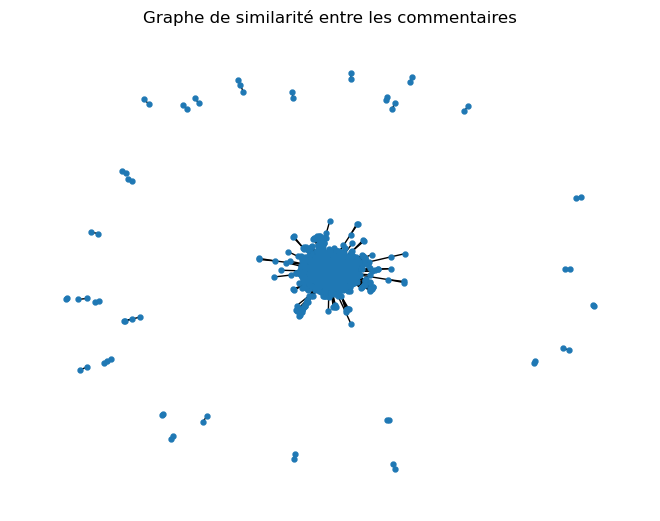

In [51]:
import matplotlib.pyplot as plt
nx.draw(G,node_shape = '.', node_size = 50)
plt.title("Graphe de similarité entre les commentaires")
plt.show()

In [52]:
# Obtenez la liste des arêtes à partir du graphe networkx
edge_list = np.array(G.edges())

# Convertissez la liste des arêtes en tensor PyTorch
edges = torch.tensor(edge_list, dtype=torch.long)

# Transposez le tensor pour obtenir la forme correcte
edges = edges.t().contiguous()
edges

tensor([[  17,   17,   17,  ..., 6370, 7054, 7991],
        [3260, 3720, 4175,  ..., 7425, 7637, 8801]])

In [53]:
edges = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(X.todense(), dtype=torch.float)

# Création d'un objet Data pour chaque graphe
data = Data(x=x, y=y, edge_index=edges)
data_list = [data]

# Création d'un DataLoader pour gérer le chargement des données pendant l'entraînement
loader = DataLoader(data_list, batch_size=32, shuffle=True)

C:\Users\sambe\AppData\Local\Temp\ipykernel_18028\2275260271.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edges, dtype=torch.long)



## Définition du modèle GNN

In [54]:
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn import GCNConv
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.argmax(x, dim=1)

In [55]:
data.y

tensor([1, 1, 1,  ..., 0, 0, 1])

## Entraînement et évaluation du modèle

In [57]:
from sklearn.metrics import accuracy_score, roc_auc_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()
torch.set_grad_enabled(True) 

def train(loader):
    model.train()

    total_loss = total_examples = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = criterion(out.float(), data.y.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()

    return loss


@torch.no_grad()
def evale(loader):
    model.eval()
    
    for data in loader:
        data = data.to(device)
        out = model(data)
        acc = accuracy_score(data.y, out)
        auc = roc_auc_score(data.y, out)
    return acc, auc

In [58]:
loss = train(loader)

acc, auc = evale(loader)
print(f'Loss: {loss:.4f}, accuracy : {acc:.4f}, '
      f'roc auc : {auc:.4f}')

Loss: 0.7165, accuracy : 0.5025, roc auc : 0.5049


## Test du modèle
Nous allons tester notre model sur les 1000 données suivantes 

In [64]:
def transform(df, vectorizer,encoder):
    X = vectorizer.transform(df['review'])
    y = encoder.transform(df['sentiment'])
    y = torch.tensor(y, dtype=torch.long)
    similarity_matrix = cosine_similarity(X)
    
    G = nx.Graph()

    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            # Si la similarité est supérieure à 0.6, ajoutez un bord entre les nœuds
            if similarity_matrix[i, j] >= 0.6:
                G.add_edge(i, j)
                
    edge_list = np.array(G.edges())
    edges = torch.tensor(edge_list, dtype=torch.long)
    edges = edges.t().contiguous()
    edges = torch.tensor(edges, dtype=torch.long)
    x = torch.tensor(X.todense(), dtype=torch.float)

    # Création d'un objet Data pour chaque graphe
    data = Data(x=x, y=y, edge_index=edges)
    data_list = [data]

    # Création d'un DataLoader pour gérer le chargement des données pendant l'entraînement
    loader = DataLoader(data_list, batch_size=32, shuffle=True)
    return loader, data

In [62]:
df_test = dataset_df[10001:20001]

In [63]:
df_test.shape

(10000, 2)

In [65]:
test_loader, data_test = transform(df_test, vectorizer, encoder)

C:\Users\sambe\AppData\Local\Temp\ipykernel_18028\861349057.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edges, dtype=torch.long)


In [66]:
test_loader

In [67]:
data_test

Data(x=[10000, 1000], edge_index=[2, 33090], y=[10000])

In [73]:
acc, auc = evale(test_loader)
print(f'Test accuracy : {acc:.4f}, '
      f'Test roc auc : {auc:.4f}')

Test accuracy : 0.5120, Test roc auc : 0.5013


In [74]:
np.unique(model(data_test))

array([0, 1], dtype=int64)